*Full project with complete code and datasets available on my Github [repository](https://github.com/ruthgn/Movie-Recommendation-System).*

In recommender systems theory, the two most common types of recommender systems are **Content-Based** and **Collaborative Filtering**. Content-based recommender systems focus on the attributes of items and give you recommendations based on similarities between them. Meanwhile, collaborative filtering produces recommendations based on the knowledge of users' attitude toward items; it uses the "wisdom of the crowd" to produce recommendations. A common example of collaborative filtering is the recommendations Amazon suggests while customers browse for a particular item. Suggestions are based on other shoppers' purchases of similar items and products purchased within the same basket.
The underlying difference between content-based and collaborative filtering lies in how the former focuses on item similarities and the latter, user preferences.

Overall, collaborative filtering is more commonly used in content based systems because it usually gives better results and is relatively easy to understand from an overall implementation perspective. This post outlines one of the approaches I use with collaborative filtering to create a simple movie recommendation system with Python. We will use the famous MovieLens dataset, which is one of the most common datasets used when implementing and testing recommender engines. It contains 100k movie ratings from 943 users and a selection of 1682 movies. You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip). Full description of the dataset is available [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).  

## Getting Started

In [1]:
# Import the libraries we will need
import numpy as np
import pandas as pd

You can download the dataset [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip) or use the **u.data** file that is included in the project Github [repository](https://github.com/ruthgn/Movie-Recommendation-System).

In [2]:
# Create new variable listing columns we want from the dataset
# Specify the separator argument for a Tab separated file when reading data
columnsNames = ['user_id', 'item_id', 'rating', 'timestamp']
# Read data
df = pd.read_csv('u.data', sep='\t', names=columnsNames)

In [3]:
# Take a quick look at the data
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


*Note*: Since movie titles are reprented by *item_id* and not the actual movie names, we will use the **Movie_ID_Titles.csv** file I've included in the project [repository](https://github.com/ruthgn/Movie-Recommendation-System) to grab and merge them with the DataFrame we've created.

In [4]:
movieTitles = pd.read_csv('Movie_Id_Titles')

In [5]:
# Quick look at Movie_ID_Titles csv file
movieTitles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [6]:
# Merge with initial dataframe
df = pd.merge(df, movieTitles, on='item_id')
# Take a look at final dataframe
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


## Exploratory Data Analysis

Let's explore the data a bit and take a look at some of the best rated movies!

In [7]:
# Import data visualization libraries and set style
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

We're going to create a ratings DataFrame that contains each movie's average rating score and total count of ratings. But before that, let's look at two groups of movies: one with *high* ratings vs one with *numerous* ratings. Be aware that movies with the highest average ratings in this data set are not necessarily box office hits given the total number of ratings. By contrast, the movie set with the highest total count of ratings does contain box office hits you're likely familiar with.

In [8]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

In [9]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

In [10]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [11]:
# Add count of rating column:
ratings['count of rating'] = df.groupby('title')['rating'].count()
ratings.head()

,rating,count of rating
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


Now let's explore the data using some visualizations:

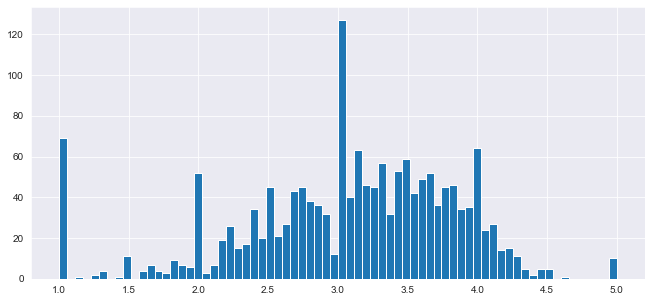

In [12]:
plt.figure(figsize=(11,5))
ratings['rating'].hist(bins=70)

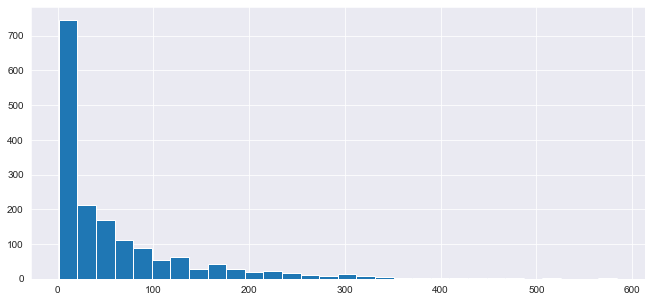

In [13]:
plt.figure(figsize=(11,5))
ratings['count of rating'].hist(bins=30)

We learned that most movies in the dataset have very few (zero or one) reviews while several others (probably considered 'blockbusters') have reviews numbering in the hundreds.

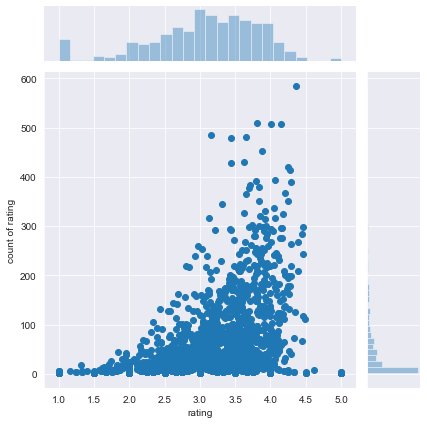

In [14]:
sns.jointplot(x='rating', y='count of rating', data=ratings)

We can also deduce that movies that have been rated by a lot of people tend to be rated positively. It's important to be aware of the fact that the rating scores contained in the dataset are skewed towards mainstream or blockbuster titles; our recommendation system performs better in recommending mainstream or blockbuster movies and for users who have watched and rated more popular titles.

Now that we have a general idea of what the data looks like, let's move on to creating a simple recommendation system:

## Recommending Similar Movies

We will build a recommendation system based on similarities in user perception. Let's create a matrix that has the user IDs on one axis and the movie title on another axis. Each cell will then consist of the rating the user gave to that movie. Note that there are a lot of NaN values because most users have not seen most of movies in the dataset.

In [15]:
moviemat = df.pivot_table(index='user_id', columns='title', values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movies:

In [16]:
ratings.sort_values('count of rating', ascending=False).head(50)

,rating,count of rating
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


I'm going to choose three very different movies to test our recommender system: **Star Wars (1977)**--a sci-fi action, **Toy Story (1995)**--an animated family comedy, and lastly, **The Silence of the Lambs (1991)**--a horror and psychological thriller.

In [17]:
# Grab the user ratings for each movie
starWarsUserRatings = moviemat['Star Wars (1977)']
toyStoryUserRatings = moviemat['Toy Story (1995)']

In [18]:
# Use corrwith() method to get correlations between two pandas series
similarToStarWars = moviemat.corrwith(starWarsUserRatings)
similarToToyStory = moviemat.corrwith(toyStoryUserRatings)

C:\Users\Ruth Nainggolan\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ruth Nainggolan\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [19]:
# Clean the data: Remove NaN values and set as a DataFrame instead of a series
corrStarWars = pd.DataFrame(similarToStarWars, columns=['Correlation'])
corrStarWars.dropna(inplace=True)
corrStarWars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


Now, if we sort the DataFrame by correlation, we should get the most similar movies. However, we will get some results that don't really make sense. This is caused by the fact that there are a lot of movies only watched once by users who also watched Star Wars (which is understandable as it was the most popular movie).

In [20]:
corrStarWars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


We will fix this by filtering out movies that have less than 100 reviews--this value was chosen based off of what we discovered from the histogram visualization during our exploratory data analysis earlier.

In [21]:
corrStarWars = corrStarWars.join(ratings['count of rating'])
corrStarWars.head()

,Correlation,count of rating
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [22]:
# Sort the values for titles to make a lot more sense
corrStarWars[corrStarWars['count of rating']>100].sort_values('Correlation',
                                                              ascending=False).head()

,Correlation,count of rating
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


These recommendations make a lot of sense! In fact, if you are a Star Wars fan you should definitely be familiar with its sequels, *The Empire Strikes Back* and *Return of the Jedi*, which make up the original Star Wars Trilogy.

Now let's do the same for Toy Story and see what recommendations are in store for us!

In [23]:
corrToyStory = pd.DataFrame(similarToToyStory, columns=['Correlation'])
corrToyStory.head()

,Correlation
title,
'Til There Was You (1997),0.534522
1-900 (1994),NaN
101 Dalmatians (1996),0.232118
12 Angry Men (1957),0.334943
187 (1997),0.651857


In [24]:
corrToyStory.dropna(inplace=True)

In [25]:
corrToyStory = corrToyStory.join(ratings['count of rating'])

In [26]:
# Sort the values and display recommendation
corrToyStory[corrToyStory['count of rating']>100].sort_values('Correlation', ascending=False).head()

,Correlation,count of rating
title,,
Toy Story (1995),1.000000,452
"Craft, The (1996)",0.549100,104
Down Periscope (1996),0.457995,101
Miracle on 34th Street (1994),0.456291,101
G.I. Jane (1997),0.454756,175


Sure enough, recommendations based off of *Toy Story* are a mix of family-friendly flicks and fun action films.

Lastly, we will check out recommendations for fans of The Silence of the Lambs. 

*Note*: I will be repeating the steps I applied previously to the two movies in the section below. When re-running this project code, you can easily replace variables representing *The Silence of Lambs* with those representing your movie of choice to get a personalized recommendation.

In [27]:
# Grab the user ratings for movie of interest
silenceOfTheLambsUserRatings = moviemat['Silence of the Lambs, The (1991)']

In [28]:
# Use corrwith() method to get correlations between two pandas series
similarToSilenceOfTheLambs = moviemat.corrwith(silenceOfTheLambsUserRatings)

C:\Users\Ruth Nainggolan\anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Ruth Nainggolan\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [29]:
# Clean the data: Remove NaN values and set as a DataFrame instead of a series
corrSilenceOfTheLambs = pd.DataFrame(similarToSilenceOfTheLambs, columns=['Correlation'])
corrSilenceOfTheLambs.dropna(inplace=True)
corrSilenceOfTheLambs = corrSilenceOfTheLambs.join(ratings['count of rating'])

In [30]:
# Sort the values and display recommendations
corrSilenceOfTheLambs[corrSilenceOfTheLambs['count of rating']>100].sort_values('Correlation',
                                                              ascending=False).head()

,Correlation,count of rating
title,,
"Silence of the Lambs, The (1991)",1.000000,390
Alien: Resurrection (1997),0.408675,124
Basic Instinct (1992),0.403709,101
"Crying Game, The (1992)",0.370926,119
Shine (1996),0.368361,129


I think the recommendations generated from *The Silence of The Lamb* are particularly great for those who enjoy thrillers and horror titles!

Are you looking for movie recommendations? Feel free to run this code yourself by accessing the project [repository](https://github.com/ruthgn/Movie-Recommendation-System) and inputing your favorite movie!